In [14]:
import os
from typing import Dict, Tuple, Union, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchdiffeq import odeint
from sklearn.model_selection import train_test_split
import numpy as np

from IPython.display import clear_output
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [15]:
## helper functions and classes
class imlocal:
    """
    STEM image local crystallography class
    highly ported from atomai https://github.com/pycroscopy/atomai/tree/master
    """

    def __init__(
        self,
        network_output: np.ndarray,
        coord_class_dict_all: Dict[int, np.ndarray],
        window_size: int = None,
        coord_class: int = 0,
    ) -> None:
        self.network_output = network_output
        self.nb_classes = network_output.shape[-1]
        self.coord_all = coord_class_dict_all
        self.coord_class = float(coord_class)
        self.r = window_size
        (self.imgstack, self.imgstack_com, self.imgstack_frames) = (
            self.extract_subimages_()
        )
        self.d0, self.d1, self.d2, self.d3 = self.imgstack.shape

    def get_imgstack(
        self,
        imgdata: np.ndarray,
        coord: np.ndarray,
        r: int,
    ) -> Tuple[np.ndarray]:

        img_cr_all = []
        com = []
        for c in coord:
            cx = int(np.around(c[0]))
            cy = int(np.around(c[1]))
            if r % 2 != 0:
                img_cr = np.copy(
                    imgdata[
                        cx - r // 2 : cx + r // 2 + 1, cy - r // 2 : cy + r // 2 + 1
                    ]
                )
            else:
                img_cr = np.copy(
                    imgdata[cx - r // 2 : cx + r // 2, cy - r // 2 : cy + r // 2]
                )
            if img_cr.shape[0:2] == (int(r), int(r)) and not np.isnan(img_cr).any():
                img_cr_all.append(img_cr[None, ...])
                com.append(c[None, ...])
        if len(img_cr_all) == 0:
            return None, None
        img_cr_all = np.concatenate(img_cr_all, axis=0)
        com = np.concatenate(com, axis=0)
        return img_cr_all, com

    def extract_subimages(
        self,
        imgdata: np.ndarray,
        coordinates: Union[Dict[int, np.ndarray], np.ndarray],
        window_size: int,
        coord_class: int = 0,
    ) -> Tuple[np.ndarray]:

        if isinstance(coordinates, np.ndarray):
            coordinates = np.concatenate(
                (coordinates, np.zeros((coordinates.shape[0], 1))), axis=-1
            )
            coordinates = {0: coordinates}
        if np.ndim(imgdata) == 2:
            imgdata = imgdata[None, ..., None]
        subimages_all, com_all, frames_all = [], [], []
        for i, (img, coord) in enumerate(zip(imgdata, coordinates.values())):
            coord_i = coord[np.where(coord[:, 2] == coord_class)][:, :2]
            stack_i, com_i = self.get_imgstack(img, coord_i, window_size)
            if stack_i is None:
                continue
            subimages_all.append(stack_i)
            com_all.append(com_i)
            frames_all.append(np.ones(len(com_i), int) * i)
        if len(subimages_all) > 0:
            subimages_all = np.concatenate(subimages_all, axis=0)
            com_all = np.concatenate(com_all, axis=0)
            frames_all = np.concatenate(frames_all, axis=0)
        return subimages_all, com_all, frames_all

    def extract_subimages_(self) -> Tuple[np.ndarray]:

        imgstack, imgstack_com, imgstack_frames = self.extract_subimages(
            self.network_output, self.coord_all, self.r, self.coord_class
        )
        return imgstack, imgstack_com, imgstack_frames


def load_dynamic_transition_data(
    data_path: str,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Load data from the given path.
    """
    STEM_real = np.load(os.path.join(data_path, "3DStack13-1-exp.npy"))
    decoded_imgs = np.load(os.path.join(data_path, "3DStack13-1-dec.npy"))
    lattice_coord = np.load(
        os.path.join(data_path, "3DStack13-1-coord.npy"), allow_pickle=True
    )[()]
    return STEM_real, decoded_imgs, lattice_coord


def make_Dataset(rawImageStack: np.ndarray, **kwargs):
    train_size = kwargs.get("train_size", 0.85)
    random_state = kwargs.get("random_state", 42)
    imstack_train, imstack_test = train_test_split(
        rawImageStack,
        train_size=train_size,
        shuffle=True,
        random_state=random_state,
    )
    train_dataset, val_dataset = TensorDataset(
        torch.from_numpy(
            imstack_train.transpose(0, 3, 1, 2).reshape(len(imstack_train), -1)
        )
    ), TensorDataset(
        torch.from_numpy(
            imstack_test.transpose(0, 3, 1, 2).reshape(len(imstack_test), -1)
        ),
    )
    return train_dataset, val_dataset


def make_DataLoader(
    TrainDataset: Dataset,
    TestDataset: Dataset,
    **kwargs,
) -> List[DataLoader]:
    """Creat PyTorch Dataloader"""
    b = kwargs.get("batch_size", 100)

    train_loader = DataLoader(
        dataset=TrainDataset,
        batch_size=b,
        shuffle=True,
        num_workers=4,
        persistent_workers=True,
    )

    val_loader = DataLoader(
        dataset=TestDataset,
        batch_size=b,
        shuffle=False,
        num_workers=4,
        persistent_workers=True,
    )

    return train_loader, val_loader

In [40]:
STEM_real, decoded_imgs, lattice_coord = load_dynamic_transition_data("../data")
s = imlocal(np.sum(decoded_imgs[..., :-1], -1)[..., None], lattice_coord, 24, 0)
imgstack, imgstack_com, imgstack_frm = s.imgstack, s.imgstack_com, s.imgstack_frames
trainDataset, valDataset = make_Dataset(imgstack)
trainDataLoader, valDataLoader = make_DataLoader(trainDataset, valDataset)

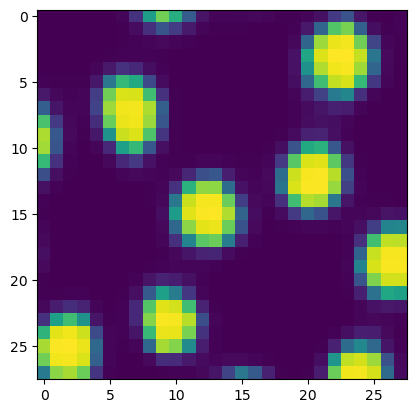

In [57]:
seq_decoded_local = np.sum(decoded_imgs[..., :-1], -1)[:, 28:56, 28:56]
plt.imshow(seq_decoded_local[0])